<a href="https://colab.research.google.com/github/Joshua1030/APS360_Team17/blob/main/Final_Baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Data Loading and Splitting
Download data from kaggle and split them into train, validation, and test sets. Data are downloded from https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification

Since the dataset contains about 10,000 images over 6 categories, it will take very long to train our model. Our team decide to randomly choose 500 images for training, 100 images for validation, and 100 images for testing, from each category. 
Datasets can be downloaded by link: https://drive.google.com/drive/folders/1vMEit7Gcn2ZQd1DnRtb2J6Gn7FbUQP4T?usp=share_link

In [1]:
#import libraries
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#make sure to use the correct address
train_dir = "/content/gdrive/MyDrive/APS360/Project_data_set/APS360_Data_Small_Train"
val_dir = "/content/gdrive/MyDrive/APS360/Project_data_set/APS360_Data_Small_Val"
test_dir = "/content/gdrive/MyDrive/APS360/Project_data_set/APS360_Data_Small_Test"

train_dir2 = "/content/gdrive/MyDrive/APS360/small_data_set/APS360_Data_Small_Train"
val_dir2 = "/content/gdrive/MyDrive/APS360/small_data_set/APS360_Data_Small_Val"
test_dir2 = "/content/gdrive/MyDrive/APS360/small_data_set/APS360_Data_Small_Test"

In [5]:
#data are downloded from https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification
classes = ('freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges')

#resize all images to 224x224
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

trainset = torchvision.datasets.ImageFolder(train_dir, transform=transform)
valset = torchvision.datasets.ImageFolder(val_dir, transform=transform)
testset = torchvision.datasets.ImageFolder(test_dir, transform=transform)

#data loader
batch_size = 16

train_loader = torch.utils.data.DataLoader(trainset, batch_size, num_workers=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size, num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size, num_workers=1, shuffle=True)

In [6]:
len(train_loader)

188

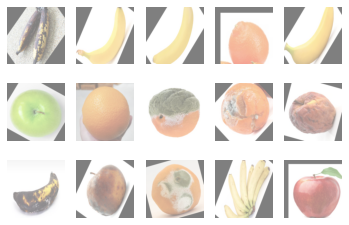

In [5]:
#Visualize data
k = 0
for images, labels in val_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    #print(labels)
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

Baseline Model

In [7]:
def get_accuracy(model, data, batch_size):
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, num_workers=1, shuffle=True)  

    correct = 0
    total = 0
    for imgs, labels in data_loader:

        # to enable GPU Usage
        # begin
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        # end

        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [8]:
import matplotlib.pyplot as plt
def train(model, train, valid, batch_size=64, num_epochs=5, learning_rate=1e-5):
    torch.manual_seed(42)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, valid_losses, train_acc, valid_acc = [], [], [], []
    epochs = []
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, num_workers=1, shuffle=True)  
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, num_workers=1, shuffle=True)  

  # training
    for epoch in range(num_epochs):
        for imgs, labels in train_loader:
        
        
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
            
              
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
        train_losses.append(float(loss))

        for imgs, labels in valid_loader:
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################

            out = model(imgs)
            loss = criterion(out, labels)
        valid_losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train, batch_size))
        valid_acc.append(get_accuracy(model, valid, batch_size))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
        model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    # plotting
    plt.title("Training Curve")
    plt.plot(train_losses, label="Train")
    plt.plot(valid_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [9]:
class Baseline(nn.Module):
    def __init__(self):
        super(Baseline, self).__init__()
        self.name = "baseline"
        self.layer1 = nn.Linear(3*224*224, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 6)
    def forward(self, img):
        a1 = img.view(img.size(0), -1)
        a2 = F.relu(self.layer1(a1))
        a3 = F.relu(self.layer2(a2))
        a4 = F.relu(self.layer3(a3))
        x = torch.sigmoid(self.layer4(a4))
        return x

CUDA is available!  Training on GPU ...
Epoch 1; Loss 1.399687; Train Acc 0.496667; Val Acc 0.505000
Epoch 2; Loss 1.402743; Train Acc 0.627000; Val Acc 0.613333
Epoch 3; Loss 1.248936; Train Acc 0.643333; Val Acc 0.610000
Epoch 4; Loss 1.486098; Train Acc 0.636333; Val Acc 0.600000
Epoch 5; Loss 1.384423; Train Acc 0.662333; Val Acc 0.630000
Epoch 6; Loss 1.272050; Train Acc 0.697333; Val Acc 0.658333
Epoch 7; Loss 1.223478; Train Acc 0.716000; Val Acc 0.678333
Epoch 8; Loss 1.337649; Train Acc 0.739667; Val Acc 0.693333
Epoch 9; Loss 1.423819; Train Acc 0.750000; Val Acc 0.708333
Epoch 10; Loss 1.207873; Train Acc 0.763667; Val Acc 0.721667
Epoch 11; Loss 1.236585; Train Acc 0.727000; Val Acc 0.693333
Epoch 12; Loss 1.129705; Train Acc 0.761667; Val Acc 0.713333
Epoch 13; Loss 1.364314; Train Acc 0.770333; Val Acc 0.710000
Epoch 14; Loss 1.243907; Train Acc 0.752333; Val Acc 0.713333
Epoch 15; Loss 1.280369; Train Acc 0.819000; Val Acc 0.773333
Epoch 16; Loss 1.158046; Train Acc 0.81

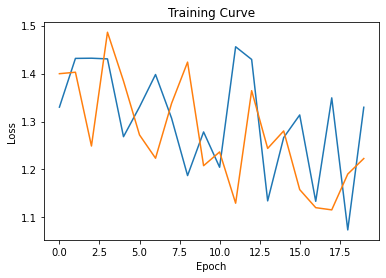

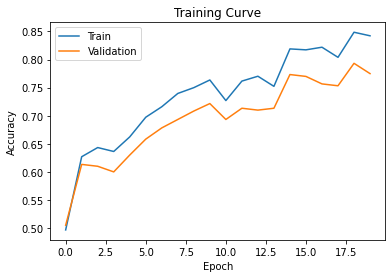

In [10]:
fruit = Baseline()
use_cuda = True
if use_cuda and torch.cuda.is_available():
  fruit.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(fruit, trainset, valset, batch_size=16, num_epochs=20, learning_rate=0.0001)